In [31]:
### Basic Imports
import pandas as pd
import numpy as np

### Graphic libraries
import matplotlib.pyplot as plt
import seaborn as sns 


### Importing the relevant ML libraries 
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn import svm
from sklearn.ensemble import RandomForestClassifier

from sklearn.metrics import accuracy_score,roc_curve,auc,recall_score,f1_score,precision_score,classification_report,confusion_matrix,auc

### Some cosmetics add-ons
plt.style.use('fivethirtyeight')
%matplotlib inline

# Loading dataset

In [32]:
df = pd.read_csv('annual_data/nba_season_2014_data.csv')
df.head()

,SEASON_ID_x,TEAM_ID_x,TEAM_ABBREVIATION_x,TEAM_NAME_x,GAME_ID,GAME_DATE_x,MATCHUP_x,WL_x,MIN_x,PTS_x,...,OFFRATE_y,DEFRATE_y,ELO_y,DIS_PTS_y,DIS_AST_y,DIS_OREB_y,DIS_DREB_y,DIS_OFFRATE_y,DIS_DEFRATE_y,DIS_ELO_y
0,22014,1610612747,LAL,Los Angeles Lakers,21400003,2014-10-28,LAL vs. HOU,0,240,90,...,0.0,0.0,1500.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,22014,1610612740,NOP,New Orleans Pelicans,21400001,2014-10-28,NOP vs. ORL,1,240,101,...,0.0,0.0,1500.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,22014,1610612742,DAL,Dallas Mavericks,21400002,2014-10-28,DAL @ SAS,0,239,100,...,0.0,0.0,1500.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,22014,1610612749,MIL,Milwaukee Bucks,21400004,2014-10-29,MIL @ CHA,0,264,106,...,0.0,0.0,1500.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,22014,1610612744,GSW,Golden State Warriors,21400014,2014-10-29,GSW @ SAC,1,239,95,...,0.0,0.0,1500.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [33]:
df.info(verbose=True , null_counts=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1230 entries, 0 to 1229
Data columns (total 111 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   SEASON_ID_x          1230 non-null   int64  
 1   TEAM_ID_x            1230 non-null   int64  
 2   TEAM_ABBREVIATION_x  1230 non-null   object 
 3   TEAM_NAME_x          1230 non-null   object 
 4   GAME_ID              1230 non-null   int64  
 5   GAME_DATE_x          1230 non-null   object 
 6   MATCHUP_x            1230 non-null   object 
 7   WL_x                 1230 non-null   int64  
 8   MIN_x                1230 non-null   int64  
 9   PTS_x                1230 non-null   int64  
 10  FGM_x                1230 non-null   int64  
 11  FGA_x                1230 non-null   int64  
 12  FG_PCT_x             1230 non-null   float64
 13  FG3M_x               1230 non-null   int64  
 14  FG3A_x               1230 non-null   float64
 15  FG3_PCT_x            1230 non-null   

In [34]:
first_half = df[(df['GAME_PLAYED_x'] <= 41) | (df['GAME_PLAYED_y'] <= 41 )]
second_half = df[(df['GAME_PLAYED_x'] > 41) & (df['GAME_PLAYED_y'] > 41 )]

# Creating our target and independent variables

In [35]:
features_list = ['DIS_ELO_x', 'HOME_COURT_x', 'DIS_OFFRATE_x', 'DIS_DEFRATE_x', 'DIS_PTS_x', 'DIS_AST_x', 'DIS_OREB_x', 'DIS_DREB_x']
target = 'WL_x'

# Plotting distribution graphs for all the variables

In [36]:
# Function to plot distribution graphs

def eda_plots(df,features_list,plot_title,fig_size):

    df[features_list].hist(bins=40,edgecolor='b',linewidth=1.0,xlabelsize=8,ylabelsize=8,grid= False,figsize=fig_size ,color='red')

    plt.tight_layout(rect=(0,0,1.2,1.2))

    # Overall title for all the plots
    plt.suptitle(plot_title,x=0.65,y=1.25,fontsize=14)

    plt.show()

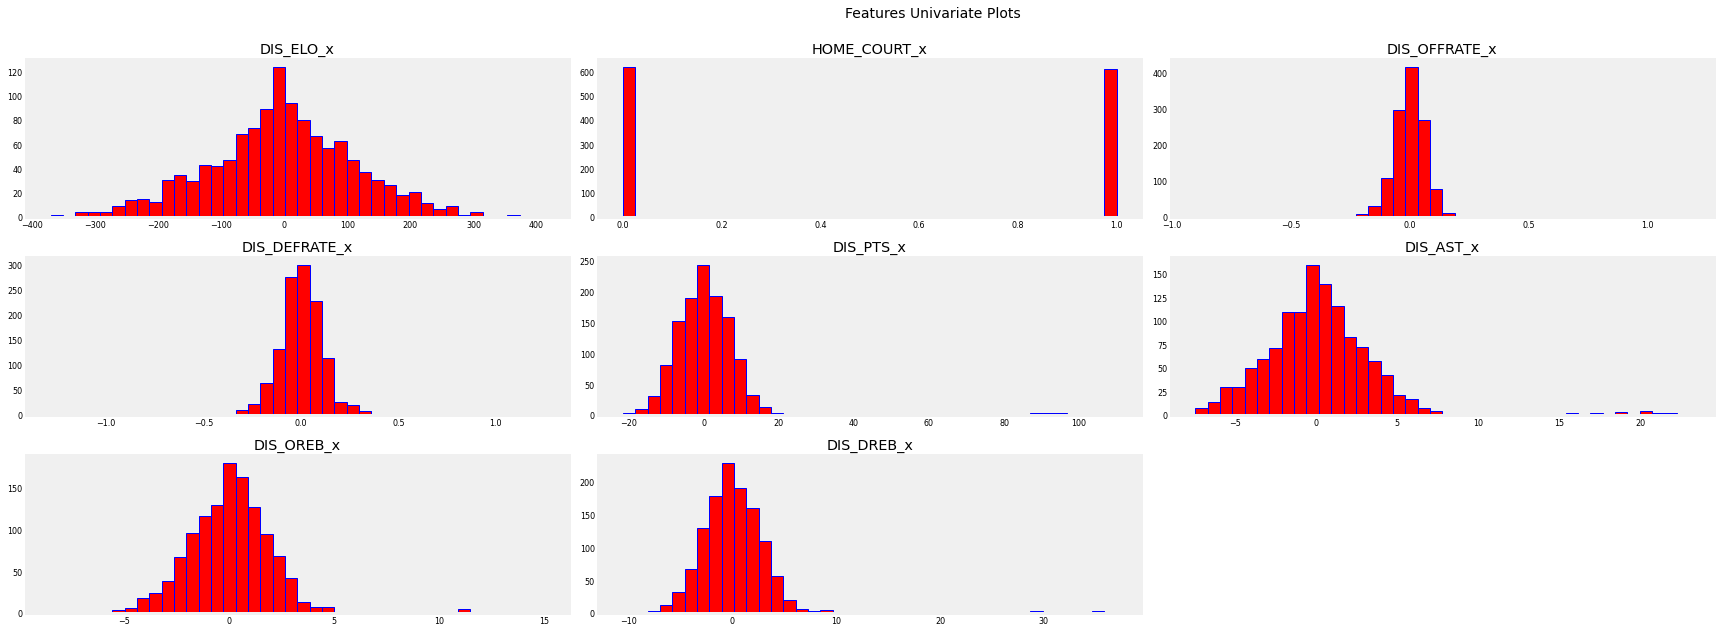

In [37]:
eda_plots(df,features_list,'Features Univariate Plots',(20,7))

All variables are relatively normally distributed. 

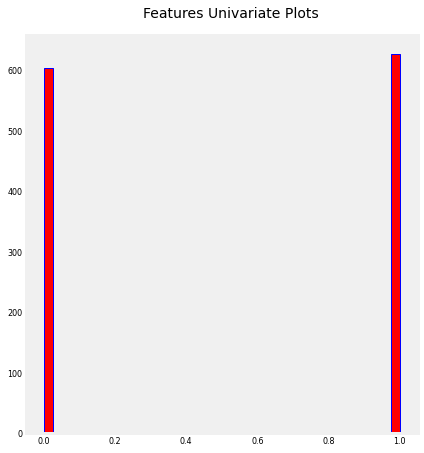

In [38]:
eda_plots(df,target,'Features Univariate Plots',(5,5))

Balanced target variable!

# Splitting dataset to train and test datasets

In [47]:
filtered_df = df[['DIS_ELO_x', 'HOME_COURT_x', 'DIS_OFFRATE_x', 'DIS_DEFRATE_x', 'DIS_PTS_x', 'DIS_AST_x', 'DIS_OREB_x', 'DIS_DREB_x']]
y = df['WL_x']

,DIS_ELO_x,HOME_COURT_x,DIS_OFFRATE_x,DIS_DEFRATE_x,DIS_PTS_x,DIS_AST_x,DIS_OREB_x,DIS_DREB_x
0,0.0,1,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,1,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0,0.0,0.0,0.0,0.0,0.0,0.0


In [40]:
X_train, X_test, y_train, y_test = train_test_split(filtered_df, y, test_size=0.3, random_state=15) 
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((861, 8), (369, 8), (861,), (369,))

# Modelling

In [41]:
models_dict = {
    'Logistic Regression':LogisticRegression(),
    'Naive Bayes':GaussianNB(),
    'Decision Trees':DecisionTreeClassifier(),
    'SVM linear': svm.SVC(kernel='linear'),
    'SVM rbf': svm.SVC(kernel='rbf'),
    'Random Forest': RandomForestClassifier()
}

performance_data = {
    'accuracy':[],
    'precision':[],
    'recall':[],
    'f1':[]
}

In [42]:
for model_name in models_dict:
    m = models_dict[model_name]
    
    m.fit(X_train, y_train)
    predictions = m.predict(X_test)

    acc = accuracy_score(y_test,predictions)  # always true label first, then your predicted labels!
    precision = precision_score(y_test,predictions) 
    recall = recall_score(y_test,predictions) 
    f1 = f1_score(y_test,predictions)

    # adding into the performance data dict
    performance_data['accuracy'].append(acc)
    performance_data['precision'].append(precision)
    performance_data['recall'].append(recall)
    performance_data['f1'].append(f1)

    print('Accuracy Score for {} is {:.5f}'.format(model_name,acc))

Accuracy Score for Logistic Regression is 0.68293
Accuracy Score for Naive Bayes is 0.67209
Accuracy Score for Decision Trees is 0.62602
Accuracy Score for SVM linear is 0.68564
Accuracy Score for SVM rbf is 0.67480
Accuracy Score for Random Forest is 0.65583


# Performance Analysis

In [43]:
performance_df = pd.DataFrame(performance_data,index=list(models_dict.keys()))
performance_df

,accuracy,precision,recall,f1
Logistic Regression,0.682927,0.688995,0.734694,0.711111
Naive Bayes,0.672087,0.658228,0.795918,0.720554
Decision Trees,0.626016,0.635514,0.693878,0.663415
SVM linear,0.685637,0.683486,0.760204,0.719807
SVM rbf,0.674797,0.688119,0.709184,0.698492
Random Forest,0.655827,0.660465,0.724490,0.690998


# Predict using every model

In [44]:
for model_name in models_dict:
    m = models_dict[model_name]
    prediction = m.predict(X_test)

    print('*'*60)
    print(f'Classification Report ({model_name}): \n')
    print(classification_report(y_test,prediction)) 

    print('-'*60)
    print('Confusion Matrix: \n')

    cm = confusion_matrix(y_test, prediction)
    cm_df = pd.DataFrame(cm,columns=[0,1],index=[0,1]) 
    # should it be columns=[1,0] instead? win = 1, lose = 0. 

    print('Predicted')
    print(cm_df,'Acutal')
    print('*'*60)
    print()
    print()

************************************************************
Classification Report (Logistic Regression): 

              precision    recall  f1-score   support

           0       0.68      0.62      0.65       173
           1       0.69      0.73      0.71       196

    accuracy                           0.68       369
   macro avg       0.68      0.68      0.68       369
weighted avg       0.68      0.68      0.68       369

------------------------------------------------------------
Confusion Matrix: 

Predicted
     0    1
0  108   65
1   52  144 Acutal
************************************************************


************************************************************
Classification Report (Naive Bayes): 

              precision    recall  f1-score   support

           0       0.70      0.53      0.60       173
           1       0.66      0.80      0.72       196

    accuracy                           0.67       369
   macro avg       0.68      0.66      0.66       

## Splitting data into first half season and second half season, instead of 70% training, 30% testing

In [53]:
X_train = first_half[['DIS_ELO_x', 'HOME_COURT_x', 'DIS_OFFRATE_x', 'DIS_DEFRATE_x', 'DIS_PTS_x', 'DIS_AST_x', 'DIS_OREB_x', 'DIS_DREB_x']]
X_test = second_half[['DIS_ELO_x', 'HOME_COURT_x', 'DIS_OFFRATE_x', 'DIS_DEFRATE_x', 'DIS_PTS_x', 'DIS_AST_x', 'DIS_OREB_x', 'DIS_DREB_x']]
y_train = first_half['WL_x']
y_test = second_half['WL_x']

X_train.shape, X_test.shape, y_train.shape, y_test.shape

((624, 8), (606, 8), (624,), (606,))

In [54]:
models_dict = {
    'Logistic Regression':LogisticRegression(),
    'Naive Bayes':GaussianNB(),
    'Decision Trees':DecisionTreeClassifier(),
    'SVM linear': svm.SVC(kernel='linear'),
    'SVM rbf': svm.SVC(kernel='rbf'),
    'Random Forest': RandomForestClassifier()
}

performance_data_1 = {
    'accuracy':[],
    'precision':[],
    'recall':[],
    'f1':[]
}

In [55]:
for model_name in models_dict:
    m = models_dict[model_name]
    
    m.fit(X_train, y_train)
    predictions = m.predict(X_test)

    acc = accuracy_score(y_test,predictions)  # always true label first, then your predicted labels!
    precision = precision_score(y_test,predictions) 
    recall = recall_score(y_test,predictions) 
    f1 = f1_score(y_test,predictions)

    # adding into the performance data dict
    performance_data_1['accuracy'].append(acc)
    performance_data_1['precision'].append(precision)
    performance_data_1['recall'].append(recall)
    performance_data_1['f1'].append(f1)

    print('Accuracy Score for {} is {:.5f}'.format(model_name,acc))

Accuracy Score for Logistic Regression is 0.66832
Accuracy Score for Naive Bayes is 0.67162
Accuracy Score for Decision Trees is 0.58086
Accuracy Score for SVM linear is 0.66832
Accuracy Score for SVM rbf is 0.66667
Accuracy Score for Random Forest is 0.65347


In [56]:
performance_df = pd.DataFrame(performance_data_1,index=list(models_dict.keys()))
performance_df

,accuracy,precision,recall,f1
Logistic Regression,0.668317,0.671924,0.687097,0.679426
Naive Bayes,0.671617,0.633094,0.851613,0.726272
Decision Trees,0.580858,0.592105,0.580645,0.586319
SVM linear,0.668317,0.675241,0.677419,0.676329
SVM rbf,0.666667,0.676471,0.667742,0.672078
Random Forest,0.653465,0.649701,0.700000,0.673913


In [58]:
for model_name in models_dict:
    m = models_dict[model_name]
    prediction = m.predict(X_test)

    print('*'*60)
    print(f'Classification Report ({model_name}): \n')
    print(classification_report(y_test,prediction)) 

    print('-'*60)
    print('Confusion Matrix: \n')

    cm = confusion_matrix(y_test, prediction)
    cm_df = pd.DataFrame(cm,columns=[0,1],index=[0,1]) 
    # should it be columns=[1,0] instead? win = 1, lose = 0. 

    print('Predicted')
    print(cm_df,'Acutal')
    print('*'*60)
    print()
    print()

************************************************************
Classification Report (Logistic Regression): 

              precision    recall  f1-score   support

           0       0.66      0.65      0.66       296
           1       0.67      0.69      0.68       310

    accuracy                           0.67       606
   macro avg       0.67      0.67      0.67       606
weighted avg       0.67      0.67      0.67       606

------------------------------------------------------------
Confusion Matrix: 

Predicted
     0    1
0  192  104
1   97  213 Acutal
************************************************************


************************************************************
Classification Report (Naive Bayes): 

              precision    recall  f1-score   support

           0       0.76      0.48      0.59       296
           1       0.63      0.85      0.73       310

    accuracy                           0.67       606
   macro avg       0.69      0.67      0.66       

# Getting actual winning percentage of a team with higher WL record

In [ ]:
for row in df.iterrows():
    